In [ ]:
### Plan ###
# 1) import all the data in torch style dataloader
# 1.5) convert data to rhytmicity plot 
# 2) Train parametric UMAP on a subset 
# 3)   

In [1]:
# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from scipy import signal
from scipy.io import wavfile
from scipy.signal import resample


import torchvision
import torchaudio
import torchvision.transforms as transforms
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
import scipy.io

## Preprocessing

In [61]:
train_bird = "/home/george-vengrovski/Documents/canary_song_detector/USA5207"
test_bird =  "/home/george-vengrovski/Documents/canary_song_detector/USA5199"

if os.path.exists(train_bird + "/joined_trained") == False:
    os.mkdir(train_bird + "/joined_trained")
if os.path.exists(test_bird + "/joined_test") == False:
    os.mkdir(test_bird + "/joined_test")

train_folders = os.listdir(train_bird)
test_folders = os.listdir(test_bird)


dst_trained = train_bird + "/joined_trained"
dst_test = test_bird + "/joined_test"

for folder in train_folders:
    if folder == "joined_trained":
        continue 

    files = os.listdir(os.path.join(train_bird, folder))
    
    for file in files:
        if file.endswith('.wav'):
            os.remove(os.path.join(train_bird, folder, file))
        else:
            for matrix in os.listdir(os.path.join(train_bird, folder, file)):
                src = os.path.join(train_bird, folder, file, matrix)
                shutil.copy(src, dst_trained)

for folder in test_folders:
    if folder == "joined_test":
        continue 

    files = os.listdir(os.path.join(test_bird, folder))
    
    for file in files:
        if file.endswith('.wav'):
            os.remove(os.path.join(test_bird, folder, file))
        else:
            for matrix in os.listdir(os.path.join(test_bird, folder, file)):
                src = os.path.join(test_bird, folder, file, matrix)
                shutil.copy(src, dst_test)

## Dataloader

In [3]:
class DetectorDataClass():
    def __init__(self, dir, spec=513):
        self.data = []
        self.spec = spec

        for file in os.listdir(dir):
            self.data.append(os.path.join(dir, file))

    def __getitem__(self, index):
        data = self.data[index]
        mat_data = scipy.io.loadmat(data)
        mat_data = mat_data["song_data"]
        mat_data = mat_data[0][0]

        arr1 = mat_data[0]
        arr2 = mat_data[1]

        # beware if spec shape changes, this might cause error
        if arr1.shape[0] == self.spec:
            arr1 = np.flip(arr1, axis=0) 
            spec = torch.Tensor(arr1.copy())
            raw_labels = torch.Tensor(arr2).int()
        else:
            arr2 = np.flip(arr2, axis=0) 
            spec = torch.Tensor(arr2.copy())
            raw_labels = torch.Tensor(arr1).int()

        if raw_labels.shape == (0,0):
            song = False
        else:
            song = True

        # labels will be the same length as the song, but it will be filled with 1s between indcies of start and stops
        labels = torch.zeros(size=(spec.shape[1],))
        if song == True:
            num_entries = raw_labels.shape[0]
            for i in range(num_entries):
                if i % 2 == 0:
                    labels[raw_labels[i]:raw_labels[i+1]].fill_(1)
        
        amplitude = spec.clone()
        amplitude = torch.sum(amplitude, dim=0)
        f, t, rythmicity = signal.spectrogram(amplitude, 1, nfft=64, noverlap=60, nperseg=64, scaling="density")
        rythmicity = rythmicity[:,:]

        rythmicity = torch.tensor(rythmicity)

        return spec, labels, song, rythmicity

    def __len__(self):
        return len(self.data) 
    
# def collate_fn(batch):
#     # Extract sequences, labels, song flags, and amplitudes
#     spec = [x[0] for x in batch]
#     labels = [x[1] for x in batch]
#     songs = [x[2] for x in batch]
#     rythmicity = [x[3] for x in batch]
    
#     # Find the max length for padding
#     max_len_spec = max([s.size(1) for s in spec])
#     max_len_labels = max([l.size(0) for l in labels])
    
#     # Pad each sequence and amplitude to max length
#     sequences_padded = [F.pad(s, (0, max_len_spec - s.size(1))) for s in spec]
#     rythmicity_padded = [F.pad(a, (0, max_len_spec - a.size(1))) for a in rythmicity]
    
#     # Pad each label to max length
#     labels_padded = [F.pad(l, (0, max_len_labels - l.size(0))) for l in labels]
    
#     # Convert lists to tensors
#     sequences_padded = torch.stack(sequences_padded)
#     labels_padded = torch.stack(labels_padded)
#     rythmicity_padded = torch.stack(rythmicity_padded)
#     songs = torch.Tensor(songs).bool()
    
#     return sequences_padded, labels_padded, songs, rythmicity_padded

train_dir = "/home/george-vengrovski/Documents/canary_song_detector/train"
test_dir = "/home/george-vengrovski/Documents/canary_song_detector/test"

train_dataset = DetectorDataClass(train_dir)
test_dataset = DetectorDataClass(test_dir)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

torch.Size([1, 33, 402])


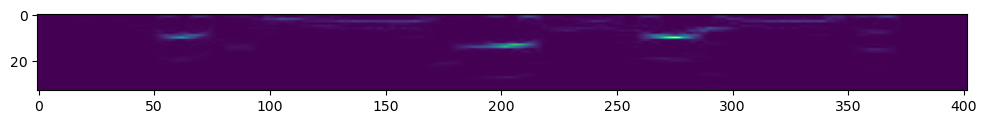

In [108]:
spec, labels, song, rhythmicity = next(iter(train_loader))

print(rhythmicity.shape)

plt.figure(figsize=(12, 20))  # Width of 12 inches and height of 8 inches

plt.imshow(rhythmicity[0].numpy())

(38721, 165)
(38721,)


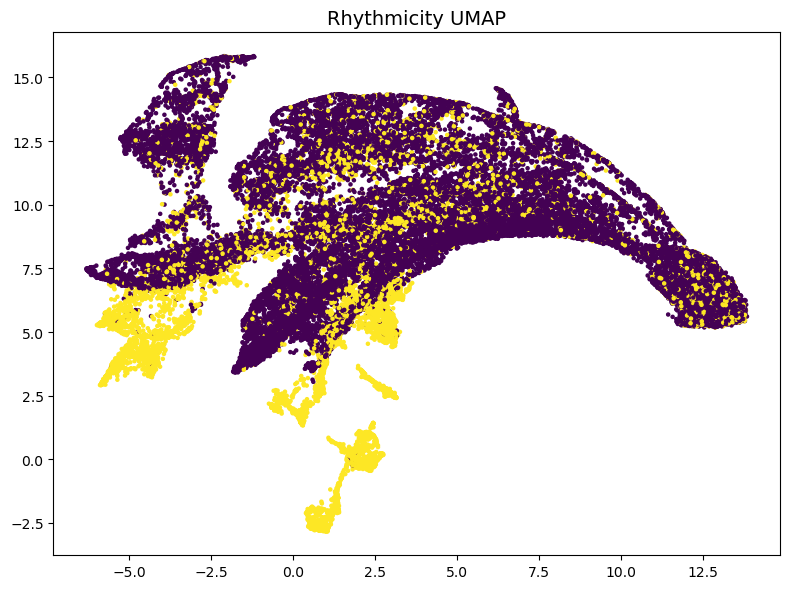

In [112]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

batch_limit = 1000
rhythmicity_arr = []
seg_length = 5 
song_arr = []
spec_arr = [] 

for i, (spec, labels, song, rhythmicity) in enumerate(train_loader):
    if i > batch_limit:
        break 
    length = rhythmicity.shape[-1]
    num_times = length // seg_length

    rhythmicity = rhythmicity.permute(0,2,1)
    rhythmicity = rhythmicity[:,:num_times*seg_length,:]
    rhythmicity = rhythmicity.reshape(rhythmicity.shape[0]*num_times, seg_length, rhythmicity.shape[2])
    rhythmicity = rhythmicity.flatten(1,2)
    rhythmicity_arr.append(rhythmicity.numpy())
    song = song.repeat(num_times)
    song_arr.append(song)

# Convert to numpy array and normalize
rhythmicity_arr_np = np.concatenate(rhythmicity_arr, axis=0)
scaler = MinMaxScaler()
rhythmicity_arr_np = scaler.fit_transform(rhythmicity_arr_np)

song_arr_np = np.concatenate(song_arr, axis=0)

print(rhythmicity_arr_np.shape)
print(song_arr_np.shape)

# Initialize UMAP reducer
reducer = umap.UMAP(random_state=42, n_neighbors=20, min_dist=0.1, n_components=2, metric='euclidean')

# UMAP projection of the data
embedding_outputs = reducer.fit_transform(rhythmicity_arr_np)

# Plotting the UMAP projection for ground truth labels
plt.figure(figsize=(8, 6))
plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=song_arr_np)
plt.title('Rhythmicity UMAP', fontsize=14)
plt.tight_layout()
plt.show()


In [113]:
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import linear_cmap
import pandas as pd
import numpy as np
from PIL import Image
import base64
from io import BytesIO

def embeddable_image(data):
    data = (data * 255).astype(np.uint8)
    image = Image.fromarray(data, 'L')  # Assuming grayscale
    im_file = BytesIO()
    image.save(im_file, format='PNG')
    im_bytes = im_file.getvalue()
    img_str = "data:image/png;base64," + base64.b64encode(im_bytes).decode()
    return img_str

# Create a color map for your song_arr_np (assuming it is boolean)
color_map = linear_cmap(field_name='colors', palette=['blue', 'red'], low=0, high=1)

output_file(filename='umap.html')

source_data = dict(
    x=embedding_outputs[:, 0],
    y=embedding_outputs[:, 1],
    image1=[],
    colors=song_arr_np.astype(int)  # True to 1, False to 0
)

for i, row in enumerate(rhythmicity_arr_np):
    reshaped_row = row.reshape(int(row.shape[0] / seg_length), seg_length)
    image_str = embeddable_image(reshaped_row)
    source_data['image1'].append(image_str)

source = ColumnDataSource(data=source_data)

p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size=5, color=color_map, source=source)

hover = HoverTool()
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image1" height="100" alt="@image1" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""
p.add_tools(hover)

save(p)


'/home/george-vengrovski/Documents/canary_song_detector/umap.html'